In [ ]:
#default_exp simclr_v2

# SimCLR v2

> [Big Self-Supervised Models are Strong Semi-Supervised Learners](https://arxiv.org/pdf/2006.10029.pdf)

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.simclr import *

## Architecture

![](images/simclr_v2.png)

Changes in SimCLRV2 doesn't require much changes in already existing `simclr` module. One difference is in `MLP` module having 3 layers instead of 2.

One thing authors argue compared to previous SimCLR framework is that scaling up the model from ResNet-50 to
ResNet-152 (3×+SK) gave 29% relative gain in top-1 accuracy when fine tuning with only 1% labeled data.

Next new change in SimCLR-v2 is a 3 layer MLP head instead of 2. Fine tune happens starting from the middle layer of MLP not only from encoder as it did previouly in SimCLR. Also, hidden size is set equal to input dimension as stated in the paper: 

> In our experiments, we set the width of projection head’s middle layers to that of its input, so it is also
adjusted by the width multiplier. However, a wider projection head improves performance even when the base
network remains narrow.

In [ ]:
#export
def create_simclrV2_model(encoder, n_in=3, hidden_size=256, projection_size=128):
    "Create SimCLR model"
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, nlayers=3) 
    apply_init(projector)
    return SimCLRModel(encoder, projector)

In [ ]:
create_mlp_module(1280, 2048, 256, nlayers=3)

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=2048, out_features=2048, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=2048, out_features=256, bias=True)
)

In [ ]:
timm_encoder = create_timm_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False)
model = create_simclrV2_model(timm_encoder, n_in=3, hidden_size=2048, projection_size=128)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

## SimCLRv2 Callback

> Important: (TODO) Memory mechanism from MOCO. Paper claims 1% improvement in linear evaluation and fine-tuning, so it's ignored for now. This is mainly valuable when large batch size can't be obtained for enough negative sampling.

In [ ]:
#export
SimCLRV2Loss = SimCLRLoss

In [ ]:
#export
class SimCLRV2(Callback):
    order,run_valid = 9,True
    def __init__(self, size, aug_func=get_batch_augs, **aug_kwargs):
        self.aug1 = aug_func(size, **aug_kwargs)
        self.aug2 = aug_func(size, **aug_kwargs)
        print(self.aug1); print(self.aug2)
                    
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        bs = self.learn.xb[0].shape[0]
        self.learn.yb = (torch.arange(bs, device=self.dls.device).roll(bs//2),)
        
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = torch.split(self.learn.x, [bs,bs])
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        show_images(images, nrows=n)

You can pass `size` to define the random resized crop size and other data augmentation arguments defined in `get_aug_pipe` through `aug_kwargs`. Also, with `show_one()` method you can inspect data augmentations as a sanity check

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=5, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_fastai_encoder(xresnet18, n_in=1, pretrained=False)
model = create_simclr_model(fastai_encoder, n_in=1, hidden_size=2048, projection_size=128)
learn = Learner(dls, model, SimCLRLoss(temp=0.5),
                cbs=[SimCLRV2(size=28, aug_func=get_batch_augs, 
                            rotate=False, jitter=False, bw=False, blur=False,
                            stats=None, cuda=False),
                     ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


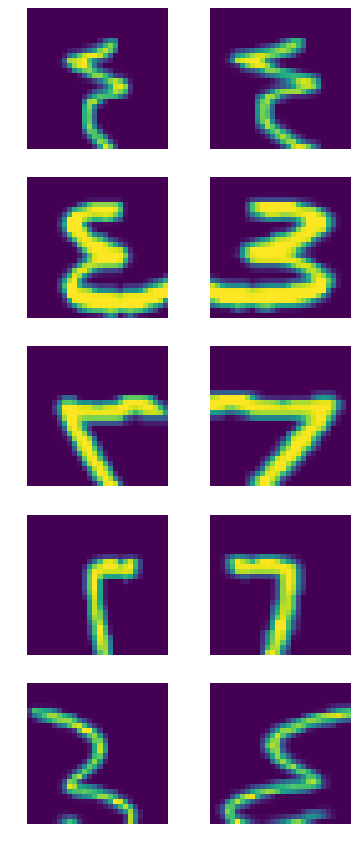

In [ ]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.sim_clrv2.show(n=5)

In [ ]:
learn.fit(1)

In [ ]:
learn.recorder.losses

[tensor(2.2862)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01-augmentations.ipynb.
Converted 02-layers.ipynb.
Converted 10-simclr.ipynb.
Converted 10b-simclr_v2.ipynb.
Converted 20-byol.ipynb.
Converted 30-swav.ipynb.
Converted index.ipynb.
